The experiments in this notebook are taken from the paper "[Using Trusted Data to Train Deep Networks on
Labels Corrupted by Severe Noise](https://arxiv.org/pdf/1802.05300.pdf)" from Berkeley published in *NIPS 2018*. 

The idea is quite simple actually: they simply train a model on the untrusted data, and they look at the predictions on a small amount of trusted data to estimate the "confusion matrix" between the model's predictions and the correct labels. Then, they train a "corrected classifier" by applying the transpose of the confusion matrix to the labels in the untrusted dataset and train on these labels instead.

It's pretty intuitive, but let's follow the derivation to understand exaclty what assumption they're making. They'd like to be able to infer $p(\tilde{y} | y)$.

The claim is that 
$$p(\tilde{y} | y) = p(\tilde{y} | y) \int{p(x | \tilde{y}, y)} dx$$
$$ =  \int{p(\tilde{y} | y, x)p(x |  y)} dx$$
$$ =  \int{p(\tilde{y} | x)p(x |  y)} dx$$

The big potential assumption is in the last line, where they assume that $\tilde{y}$ and $y$ are conditionally independent given $x$.

Then, they estimate the integral by simply taking the expectation over all of $x$'s in the trusted dataset where the label is a given value. Let's see how well this actually works and run an experiment from their method.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
%matplotlib inline

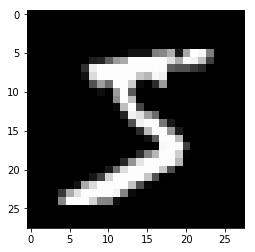

In [85]:
# Show one of the images from the training dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32').reshape(-1, 28, 28, 1) / 255
x_test = x_test.astype('float32').reshape(-1, 28, 28, 1) / 255

encoder = sklearn.preprocessing.OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

### Create Trusted and Untrusted Datasets

In [148]:
n_trust = int(0.01 * 60000)
x_trust = x_train[:n_trust]
y_trust = y_train[:n_trust]

flip_frac = 0.6
# confusion = (1-flip_frac)*np.eye(10) + flip_frac*np.ones((10, 10))/10
confusion = np.zeros((10, 10))
offset = np.random.randint(1, 10)

for i in range(10):
    new_label = (i + offset) % 10
    confusion[i, new_label] = flip_frac
    confusion[i, i] = 1 - flip_frac

x_train = x_train[n_trust:]
y_train = y_train[n_trust:]
y_train_corrupted = np.zeros_like(y_train)

for i in range(y_train.shape[0]):
    current_label = y_train[i].argmax()
    new_label = np.random.choice(10, p=confusion[current_label])
    y_train_corrupted[i, new_label] = 1

print('Untrusted Training:', x_train.shape)
print('Trusted Training:', x_trust.shape)
print('Test:', x_test.shape)

Untrusted Training: (57000, 28, 28, 1)
Trusted Training: (600, 28, 28, 1)
Test: (10000, 28, 28, 1)


In [149]:
confusion

array([[0.4, 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.4, 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.4, 0. , 0. , 0. , 0.6, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0.6, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0.6, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. , 0.6],
       [0.6, 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. ],
       [0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. ],
       [0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0.4, 0. ],
       [0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0.4]])

In [150]:
print(y_train_corrupted.sum(axis=0))

[5641. 6109. 5572. 5728. 5608. 6038. 5678. 5878. 5517. 5231.]


### Define Model

In [88]:
def get_model():
    model = tf.keras.Sequential()
    # Must define the input shape in the first layer of the neural network
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    return model

model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
__________

### Run 2 Basic Baselines
* Trusted Only
* Untrusted Only

In [91]:
trusted_only_model = get_model()
trusted_only_model.fit(x_trust,
                       y_trust,
                       batch_size=64,
                       epochs=10,
                       verbose=0)

# Evaluate the model on test set
score = trusted_only_model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy of trusted only model:', score[1])


 Test accuracy of trusted only model: 0.8534


In [270]:
trusted_only_model = get_model()
trusted_only_model.fit(x_trust,
                       y_trust,
                       batch_size=64,
                       epochs=20,
                       verbose=1)

# Evaluate the model on test set
score = trusted_only_model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy of trusted only model (20 epochs):', score[1])

Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 2.2246 - acc: 0.2100
Epoch 2/20
600/600 [==============================] - 1s 2ms/sample - loss: 1.7779 - acc: 0.5067
Epoch 3/20
600/600 [==============================] - 1s 2ms/sample - loss: 1.1948 - acc: 0.6217
Epoch 4/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.9253 - acc: 0.6867
Epoch 5/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.8111 - acc: 0.7283
Epoch 6/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.6887 - acc: 0.7750
Epoch 7/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.6010 - acc: 0.8017
Epoch 8/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.5049 - acc: 0.8250
Epoch 9/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.5500 - acc: 0.8150
Epoch 10/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.4371 - acc: 0.8483
Epoch 11/20
600/600 [========

In [151]:
untrusted_only_model = get_model()
untrusted_only_model.fit(x_train,
                         y_train_corrupted,
                         batch_size=64,
                         epochs=10,
                         verbose=1)

# Evaluate the model on test set
score = untrusted_only_model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy of untrusted only model:', score[1])

Epoch 1/10
57000/57000 [==============================] - 63s 1ms/sample - loss: 1.0868 - acc: 0.4899
Epoch 2/10
57000/57000 [==============================] - 100s 2ms/sample - loss: 0.8339 - acc: 0.5453
Epoch 3/10
57000/57000 [==============================] - 112s 2ms/sample - loss: 0.7951 - acc: 0.5559
Epoch 4/10
57000/57000 [==============================] - 82s 1ms/sample - loss: 0.7787 - acc: 0.5616
Epoch 5/10
57000/57000 [==============================] - 110s 2ms/sample - loss: 0.7640 - acc: 0.5666
Epoch 6/10
57000/57000 [==============================] - 103s 2ms/sample - loss: 0.7596 - acc: 0.5655
Epoch 7/10
57000/57000 [==============================] - 88s 2ms/sample - loss: 0.7516 - acc: 0.5689
Epoch 8/10
57000/57000 [==============================] - 92s 2ms/sample - loss: 0.7466 - acc: 0.5714
Epoch 9/10
57000/57000 [==============================] - 101s 2ms/sample - loss: 0.7413 - acc: 0.5724
Epoch 10/10
57000/57000 [==============================] - 113s 2ms/sample - 

### Get Confusion Matrix

In [152]:
from sklearn.metrics import confusion_matrix

y_pred = untrusted_only_model.predict(x_trust)

cf = confusion_matrix(y_trust.argmax(axis=1), y_pred.argmax(axis=1))
cf

array([[ 2,  0,  0,  0, 58,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0, 64,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  0,  0, 52,  0,  0,  0],
       [ 0,  1,  0,  3,  0,  0,  0, 60,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0, 61,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  1,  1, 37],
       [62,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 63,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0, 46,  0,  0,  0,  0,  0,  2]], dtype=int64)

### "Correct" Labels and Rerun 

In [153]:
y_train_corrected = y_train_corrupted.dot(cf.T)
y_train_corrected = (y_train_corrected.T / np.sum(y_train_corrected.T, axis=0)).T

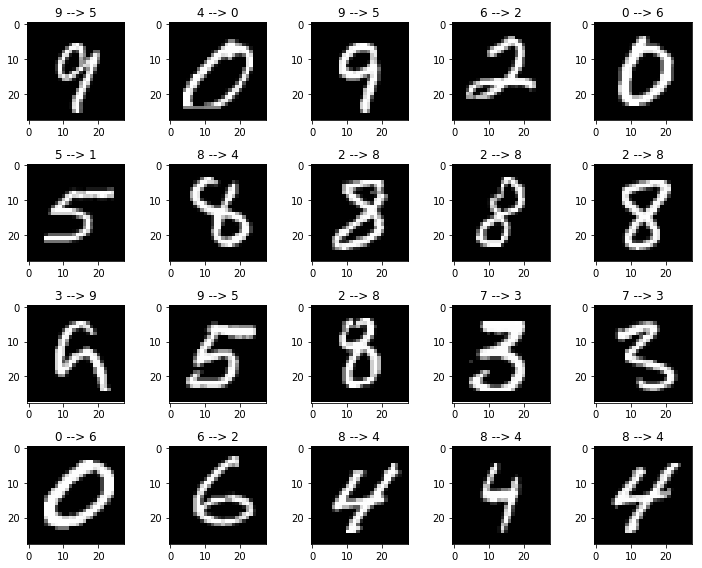

In [167]:
plt.figure(figsize=(10, 8))
offset = 20

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(x_train[offset+i].reshape(28, 28), cmap='gray')
    plt.title('{} --> {}'.format(y_train_corrupted[offset+i].argmax(), y_train_corrected[offset+i].argmax()))
plt.tight_layout()

In [154]:
corrected_model = get_model()
corrected_model.fit(x_train,
                    y_train_corrected,
                    batch_size=64,
                    epochs=10,
                    verbose=1)

# Evaluate the model on test set
score = corrected_model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy of corrected model:', score[1])

Epoch 1/10
57000/57000 [==============================] - 124s 2ms/sample - loss: 1.1999 - acc: 0.4976
Epoch 2/10
57000/57000 [==============================] - 137s 2ms/sample - loss: 0.9949 - acc: 0.5506
Epoch 3/10
57000/57000 [==============================] - 125s 2ms/sample - loss: 0.9619 - acc: 0.5602
Epoch 4/10
57000/57000 [==============================] - 115s 2ms/sample - loss: 0.9478 - acc: 0.5636
Epoch 5/10
57000/57000 [==============================] - 125s 2ms/sample - loss: 0.9386 - acc: 0.5669
Epoch 6/10
57000/57000 [==============================] - 129s 2ms/sample - loss: 0.9302 - acc: 0.5709
Epoch 7/10
57000/57000 [==============================] - 105s 2ms/sample - loss: 0.9239 - acc: 0.5721
Epoch 8/10
57000/57000 [==============================] - 105s 2ms/sample - loss: 0.9190 - acc: 0.5745
Epoch 9/10
57000/57000 [==============================] - 101s 2ms/sample - loss: 0.9141 - acc: 0.5758
Epoch 10/10
57000/57000 [==============================] - 105s 2ms/sampl

### Nonlinear Corrections

In [244]:
def get_error_correcting_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(30, )))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    return model

ecm = get_error_correcting_model()
ecm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_44 (Dense)             (None, 10)                650       
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
_________________________________________________________________


In [250]:
x_trust_feat = x_trust.reshape(-1, 784)[:, list(range(10, 784, 40))]

In [251]:
y_noisy = np.concatenate((y_pred, x_trust_feat), axis=1)

In [247]:
ecm.fit(y_noisy, y_trust, batch_size=32, epochs=20, verbose=1, validation_split=0.2)

Train on 480 samples, validate on 120 samples
Epoch 1/20
480/480 [==============================] - 1s 1ms/sample - loss: 2.3103 - acc: 0.1021 - val_loss: 2.2514 - val_acc: 0.1750
Epoch 2/20
480/480 [==============================] - 0s 81us/sample - loss: 2.2023 - acc: 0.3000 - val_loss: 2.1510 - val_acc: 0.4000
Epoch 3/20
480/480 [==============================] - 0s 77us/sample - loss: 2.1002 - acc: 0.4396 - val_loss: 2.0493 - val_acc: 0.5167
Epoch 4/20
480/480 [==============================] - 0s 94us/sample - loss: 1.9895 - acc: 0.6208 - val_loss: 1.9361 - val_acc: 0.7083
Epoch 5/20
480/480 [==============================] - 0s 90us/sample - loss: 1.8692 - acc: 0.7563 - val_loss: 1.8072 - val_acc: 0.7917
Epoch 6/20
480/480 [==============================] - 0s 94us/sample - loss: 1.7331 - acc: 0.8250 - val_loss: 1.6692 - val_acc: 0.8083
Epoch 7/20
480/480 [==============================] - 0s 121us/sample - loss: 1.5836 - acc: 0.8604 - val_loss: 1.5157 - val_acc: 0.8583
Epoch 8/2

In [253]:
x_train_feat = np.concatenate((y_train_corrupted, x_train.reshape(-1, 784)[:, list(range(10, 784, 40))]), axis=1)

In [254]:
y_train_corrected_nonlinear = ecm.predict(x_train_feat)

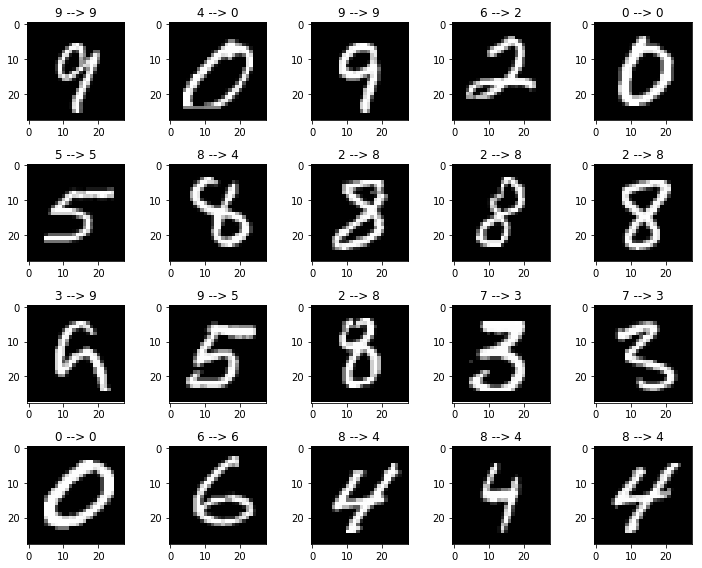

In [255]:
plt.figure(figsize=(10, 8))
offset = 20

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(x_train[offset+i].reshape(28, 28), cmap='gray')
    plt.title('{} --> {}'.format(y_train_corrupted[offset+i].argmax(), y_train_corrected_nonlinear[offset+i].argmax()))
plt.tight_layout()

In [266]:
len(np.where(y_train.argmax(axis=1) == y_train_corrupted.argmax(axis=1))[0])/y_train.shape[0]

0.3988421052631579

In [265]:
len(np.where(y_train.argmax(axis=1) == y_train_corrected.argmax(axis=1))[0])/y_train.shape[0]

0.6011578947368421

In [267]:
len(np.where(y_train.argmax(axis=1) == y_train_corrected_nonlinear.argmax(axis=1))[0])/y_train.shape[0]

0.7642456140350877

In [268]:
nonlinear_corrected_model = get_model()
nonlinear_corrected_model.fit(x_train,
                              y_train_corrected_nonlinear,
                              batch_size=64,
                              epochs=10,
                              verbose=1)

# Evaluate the model on test set
score = nonlinear_corrected_model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy of corrected model:', score[1])

Epoch 1/10
57000/57000 [==============================] - 65s 1ms/sample - loss: 1.4189 - acc: 0.6802
Epoch 2/10
57000/57000 [==============================] - 69s 1ms/sample - loss: 1.2932 - acc: 0.7332
Epoch 3/10
57000/57000 [==============================] - 96s 2ms/sample - loss: 1.2745 - acc: 0.7413
Epoch 4/10
57000/57000 [==============================] - 80s 1ms/sample - loss: 1.2634 - acc: 0.7448
Epoch 5/10
57000/57000 [==============================] - 78s 1ms/sample - loss: 1.2577 - acc: 0.7472
Epoch 6/10
57000/57000 [==============================] - 97s 2ms/sample - loss: 1.2518 - acc: 0.7476
Epoch 7/10
57000/57000 [==============================] - 96s 2ms/sample - loss: 1.2475 - acc: 0.7488
Epoch 8/10
57000/57000 [==============================] - 88s 2ms/sample - loss: 1.2450 - acc: 0.7501
Epoch 9/10
57000/57000 [==============================] - 101s 2ms/sample - loss: 1.2428 - acc: 0.7501
Epoch 10/10
57000/57000 [==============================] - 131s 2ms/sample - loss

In [273]:
y_train_corrected_nonlinear[0]

array([0.00190609, 0.00117306, 0.00331415, 0.00427606, 0.00973294,
       0.3799554 , 0.0091845 , 0.01151247, 0.01257453, 0.56637084],
      dtype=float32)

In [281]:
y_train_corrected_nonlinear_constrained = encoder.fit_transform(y_train_corrected_nonlinear.argmax(axis=1).reshape(-1, 1))
y_train_corrected_nonlinear_constrained.shape

(57000, 10)

In [290]:
import termcolor
from termcolor import colored


In [296]:
print('d', end=' ')
print(colored('hello', 'red'), end=' ')
print('d', end=' ')
print(colored('worlddd', 'green'), end=' ')
print()

d hello d worlddd 


In [1]:
import matplotlib.pyplot as plt



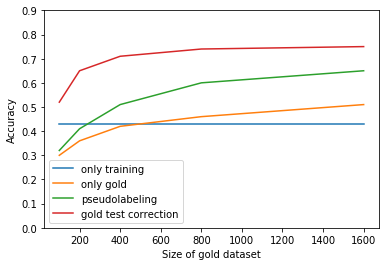

In [22]:
ns = [100, 200, 400, 800, 1600]

plt.plot(ns, [0.43]*5, label='only training')
plt.plot(ns, [0.3, 0.36, 0.42, 0.46, 0.51], label='only gold')
plt.plot(ns, [0.32, 0.41, 0.51, 0.6, 0.65], label='pseudolabeling')
plt.plot(ns, [0.52, 0.65, 0.71, 0.74, 0.75], label='gold test correction')
plt.ylim([0, 0.9])
plt.xlabel('Size of gold dataset')
plt.ylabel('Accuracy')
plt.legend()